# Spectral Clustering

## Important imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from scipy.spatial import distance_matrix as distanceMatrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import KMeans

## Functions to load and preprocess data

In [2]:
def loadData(path):
    data = pd.read_csv(path)
    x = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values
    return x, y

def splitData(x, y, train_size):
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=train_size, random_state=0, stratify=y)
    return x_train, x_test, y_train, y_test

def preprocessData(x):
    
    # Encoding the categorical data
    ct = ColumnTransformer( [('one_hot_encoder', OneHotEncoder(), [1, 2, 3])], remainder='passthrough' )
    ct = ct.fit(x)
    x = pd.DataFrame(ct.transform(x))

    # Scaling the data since the features are in different scales
    scaler = StandardScaler()
    scaler = scaler.fit(x)
    x = pd.DataFrame(scaler.transform(x))
    return x

## The Algorithm

In [3]:
def constructWeightMatrix(data, gamma = 10):
    K=rbf_kernel(data, gamma=gamma)#the kernel matrix
    K_symmetric=(K+K.T)/2
    #to make it symmetric
    n=25#as the number of features are 122
    A=kneighbors_graph(K_symmetric, n_neighbors=n, mode='connectivity')#creating the connectivity graph
    A=A.toarray()#toconvert it from sparse to dense matrix to be used in the spectral clustering
    A_symmetric=(A+A.T)/2#to make it symmetric
    A_symmetric[A_symmetric > 0] = 1 
    return A_symmetric

def clusteringUsingNormalizedCut(data, k, gamma = 10, y = None):
    # Constructing the weight matrix
    weight_matrix = constructWeightMatrix(data, gamma=gamma)

    # Computing the degree matrix
    degree_matrix = np.diag(np.sum(weight_matrix, axis=1))

    # Computing the laplacian matrix
    laplacian_matrix = degree_matrix - weight_matrix

    # Computing the eigenvalues and eigenvectors of the laplacian matrix
    eigenvalues, eigenvectors = np.linalg.eig(np.linalg.inv(degree_matrix).dot(laplacian_matrix))
    
    # Taking the only first k eigenvectors
    eigenvectors = eigenvectors[:, :k]

    # Taking only the real part of the eigenvectors
    eigenvectors = np.real(eigenvectors)

    # Convert the eigenvectors to pd dataframe
    eigenvectors = pd.DataFrame(eigenvectors)
    
    # Normalizing the eigenvectors
    eigenvectors = eigenvectors.apply(lambda x: (x - np.mean(x)) / np.std(x), axis=0)
    
    print(eigenvectors.shape)
    # Applying k-means on the eigenvectors
    kmeans = KMeans(n_clusters=k, random_state=0).fit(eigenvectors)

    # Getting the labels of the points
    labels = kmeans.labels_ 

    # Create a list of clusters of size k
    cluster = [[] for i in range(k)]

    # Assign each point to its cluster
    for i in range(len(labels)):
        cluster[labels[i]].append(i)
    
    # Create array name clusterLabels to store the labels of the clusters based on the most frequent label in the cluster in y
    clusterLabels = []
    for i in range (k):
        counterLabels = {}
        for j in range(len(cluster[i])):
            counterLabels[y[cluster[i][j]]] = counterLabels.get(y[cluster[i][j]], 0) + 1
        # Assign the most frequent label to the cluster
        maxLabel = max(counterLabels, key=counterLabels.get)
        clusterLabels.append(maxLabel)
    
    pointsLabels = []
    for i in range(len(labels)):
        pointsLabels.append(clusterLabels[labels[i]])

    return cluster, pointsLabels

## Loading the Raw Data

In [ ]:
# Loading the data
x, y = loadData('archive/kddcup.data.corrected')

## Preprocessing the Data

In [ ]:
x = preprocessData(x)
print("The shape of the training data is: ", x.shape)

## Splitting the Data

In [ ]:
# Splitting the data into train and test
x_train, x_test, y_train, y_test = splitData(x, y, train_size= 0.00025)

## Saving the Data

In [ ]:
# Save the x_train and y_train as numpy arrays
np.save('hierarchicalClustering-Preprocessed/x_train.npy', x_train)
np.save('hierarchicalClustering-Preprocessed/y_train.npy', y_train)

## Loading the Preprocessed Data

In [4]:
# Loading the preprocessed data as numpy arrays
x_train = np.load('Clustering_data-preprocessed/x_train.npy', allow_pickle=True)
y_train = np.load('Clustering_data-preprocessed/y_train.npy', allow_pickle=True)

## Evaluation

In [5]:
clusters, y_pred = clusteringUsingNormalizedCut(x_train, 23, gamma=0.1, y=y_train)
y_pred = np.array(y_pred)

(1224, 23)


C:\Users\Yousef\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [6]:
print("Weight")
print("Precision: ", precision_score(y_train, y_pred, average='weighted'))
print("Recall: ", recall_score(y_train, y_pred, average='weighted'))
print("F1 score: ", f1_score(y_train, y_pred, average='weighted'))
print("Accuracy: ", accuracy_score(y_train, y_pred))

print("-" * 100)
print("Macro")
print("Precision: ", precision_score(y_train, y_pred, average='macro'))
print("Recall: ", recall_score(y_train, y_pred, average='macro'))
print("F1 score: ", f1_score(y_train, y_pred, average='macro'))
print("Accuracy: ", accuracy_score(y_train, y_pred))

print("-" * 100)
print(classification_report(y_train, y_pred))
print("-" * 100)

# Now let's measure the conditional entropy of the clusters
totalEntropy = 0
for i in range(len(clusters)):
    entropy = 0
    counterLabels = {}
    for j in range(len(clusters[i])):
        counterLabels[y_train[clusters[i][j]]] = counterLabels.get(y_train[clusters[i][j]], 0) + 1
    for key in counterLabels:
        counterLabels[key] = counterLabels[key] / len(clusters[i])
    for key in counterLabels:
        entropy -= counterLabels[key] * np.log2(counterLabels[key])
        
    totalEntropy += entropy

totalEntropy = totalEntropy / len(clusters)
print("The conditional entropy of the clusters is: ", totalEntropy)

Weight
Precision:  0.9733648188146392
Recall:  0.9820261437908496
F1 score:  0.9776563039497949
Accuracy:  0.9820261437908496
----------------------------------------------------------------------------------------------------
Macro
Precision:  0.4167923945104122
Recall:  0.42232400607193316
F1 score:  0.41953190057823203
Accuracy:  0.9820261437908496
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

    ipsweep.       0.00      0.00      0.00         3
    neptune.       0.96      0.99      0.97       268
       nmap.       0.00      0.00      0.00         1
     normal.       0.96      0.97      0.96       243
  portsweep.       0.00      0.00      0.00         3
      satan.       0.00      0.00      0.00         4
      smurf.       1.00      1.00      1.00       702

    accuracy                           0.98      1224
   macro avg       0.42      0.42      0.42      1224
wei

C:\Users\Yousef\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Yousef\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Yousef\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarnin

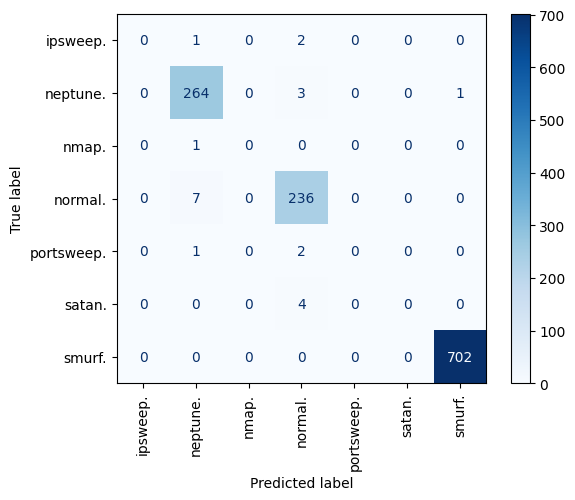

In [7]:
# Printing the confusion matrix
cm = confusion_matrix(y_train, y_pred)
# Displaying the confusion matrix in much bigger size
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train))
disp.plot(cmap=plt.cm.Blues, values_format='d', xticks_rotation='vertical')
plt.show()